# The Probability Integral Transform (PIT)

The probability intergral transform (PIT) provides a method for assessing to what extent a forecast system is probabililistically calibrated, and may help diagnose particular types of miscalibration. A forecast system is probabilistically calibrated if random draws from its predictive distributions are statistically indistinguishable from the corresponding observations.

The classical definition of the PIT for a particular forecast-observation case is $\mathrm{PIT}(F,y) = F(y)$, where $F$ is the predictive cumulative distribution function (CDF) and $y$ is the value of the observation. If the predictive CDFs are all continuous, and the forecast system is probabililistically calibrated, then the set of all PIT values $F(y)$ across the set of all forecast-observation cases will be approximately uniformly distributed on the unit interval $[0,1]$.

This definition of PIT needs adjustment to account for cases when the predictive CDFs are discontinuous. Dicontinuous CDFs commonly occur with forecasts of precipitation, which is a mixture distribution with two components: the probability of dry conditions and the probability of precipitation given that precipitation occurs. The `scores` implementation of PIT handles discontinuous predictive CDFs as well as continuous predictive CDFs. It does this by keeping track of left-hand and right-hand limits of $F(y)$. We'll get onto this later in the tutorial.

The `scores` implementation of PIT also handles inputs in three basic forms:

1. Inputs are the values $F(y)$ for each of the forecast-observation cases (or possibly the left-hand and right-hand limits of $F$ at $y$ if $F$ has discontinuities), as calculated by the user. This uses the class `scores.probability.Pit_fcst_at_obs`.
2. Inputs are the forecasts and corresponding observations, where the forecasts are in the form of an ensemble. In this case, the predictive CDFs are treated as empirical CDFs derived from the ensemble values. This uses the class `scores.probability.Pit` with the `fcst_type='ensemble'` option.
3. Inputs are the forecasts and corresponding observations, where the forecasts are arrays specifing the values (or left- and right-hand limits) of each predictive CDF at a specified set of points $x$. If an observation $y$ is not one of specified points $x$, then the value of $f$ at $y$ is deterrmined using linear interpolation. This uses the class `scores.probability.Pit` with the `fcst_type='cdf'` option.

Both PIT classes then have identical methods for calculating statistics for PIT histograms, PIT diagrams (i.e. PIT uniform probability plots), the variance and expected value of PIT across all forecast cases, and the so-called alpha score. These methods and classes are demonstrated in this tutorial.

For ensemble forecasts, `scores.probability.rank_histogram` also provides a method for computing rank histograms, which are closely related to PIT histograms. See the [tutorial on rank histograms](./Rank_Histogram.ipynbipynb) for further information.


## Case study 1: Predictive CDFs are parametric distributions and continous

This case study looks at predictive CDFs that are normal distributions. It will also examine some classic types of probabilistic (mis)-calibration
their characteristic PIT histograms and PIT uniform probability plots.

We consider a process $Y_t$, where $t=0, 1, \ldots, m$, which is generated by independent sampling from the normal distribution
as follows:
$$ Y_t \sim N(\mu_t, 1), \qquad\text{where } \mu_t\sim N(0, 1).$$

We consider six different forecasters who issue predictive CDFs as follows:

1. **Calibrated (ideal) forecaster**: forecasts are $N(\mu_t, 1)$.
2. **Over-prediction forecaster**: forecasts are $N(\mu_t + 0.3, 1)$. That is, forecast distribution lies to the right of the true distribution. 
3. **Under-prediction forecaster**: forecasts are $N(\mu_t - 0.3, 1)$. That is, forecast distribution lies to the left of the true distribution. 
4. **Over-dispersed forecaster**: forceasts are $N(\mu_t, (1.3)^2)$. That is, forecast distribution is wider than the true distribution. 
5. **Under-dispersed forecaster**: forceasts are $N(\mu_t, (1/1.3)^2)$. That is, forecast distribution is narrower than the true distribution. 
6. **Calibrated (marginal) forecaster**: forceasts are $N(0, 2)$. That is, this forecast distribution well-calibrated but has no knowledge of $\mu_t$. This is equivalent to issuing the climatological forecast for a meteorological process. Forecasts are reliable over the long-run but not accurate.

We'll generate some observations $y$, evaluate them at the forecast CDFs $F$, and then use the `Pit_fcst_at_obs` class to generate standard statistics and diagrams.



In [1]:
import numpy as np
import xarray as xr
from scipy.stats import norm
import matplotlib.pyplot as plt
from scores.probability import Pit, Pit_fcst_at_obs


n_time = 10000  # total time steps

# generate values for mu_t
np.random.seed(seed=42)
mu = norm.rvs(loc = 0, scale = 1, size=n_time)

# generate the observations
obs = xr.DataArray(
    data=norm.rvs(loc = mu, scale = 1, size=n_time),
    dims=['time'],
    coords={'time': range(n_time)},
    name='obs',
)
# calculate the observations evaluated at the forecast CDFs
fcstA_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu, scale = 1),
    dims=['time'],
    coords={'time': range(n_time)},
    name='calibrated (ideal)',
)
fcstB_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu + 0.3, scale = 1),
    dims=['time'],
    coords={'time': range(n_time)},
    name='over-prediction',
)
fcstC_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu - 0.3, scale = 1),
    dims=['time'],
    coords={'time': range(n_time)},
    name='under-prediction',
)
fcstD_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu, scale = 1.3),
    dims=['time'],
    coords={'time': range(n_time)},
    name='over-dispersed',
)
fcstE_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = mu, scale = 1 / 1.3),
    dims=['time'],
    coords={'time': range(n_time)},
    name='under-dispersed',
)
fcstF_at_obs = xr.DataArray(
    data=norm.cdf(obs, loc = 0, scale = np.sqrt(2)),
    dims=['time'],
    coords={'time': range(n_time)},
    name='calibrated (marginal)',
)

# combine forecasts evaulated at obs into a list
fcst_at_obs_list = [fcstA_at_obs, fcstB_at_obs, fcstC_at_obs, fcstD_at_obs, fcstE_at_obs, fcstF_at_obs]

# generate the Pit class for each forecast system
pit_list = [Pit_fcst_at_obs(fcst_at_obs) for fcst_at_obs in fcst_at_obs_list]


### The PIT histogram

The PIT histogram displays the the relative frequency with which observations fall at different quantile levels of the predictive CDFs. If the forecast system is well calibrated then the histogram should be fairly flat. Let's look at the output of the `.hist_values` method, then produce a plot of the PIT histogram for each forecaster.

In [2]:
# We'll calculate the histogram values for each forecast system

n_bins = 20  # number of bins in the PIT histogram
histogram_values = [pit.hist_values(n_bins) for pit in pit_list]

# look at the output for the "calibrated (ideal)" forecaster
histogram_values[0]

<xarray.DataArray 'calibrated (ideal)' (bin_centre: 20)> Size: 160B
array([0.0476, 0.0484, 0.0472, 0.0489, 0.0528, 0.0537, 0.0477, 0.0495,
       0.0494, 0.048 , 0.0542, 0.0521, 0.0476, 0.0508, 0.047 , 0.0496,
       0.0518, 0.0496, 0.0521, 0.052 ])
Coordinates:
  * bin_centre          (bin_centre) float64 160B 0.025 0.075 ... 0.925 0.975
    bin_left_endpoint   (bin_centre) float64 160B 0.0 0.05 0.1 ... 0.85 0.9 0.95
    bin_right_endpoint  (bin_centre) float64 160B 0.05 0.1 0.15 ... 0.9 0.95 1.0

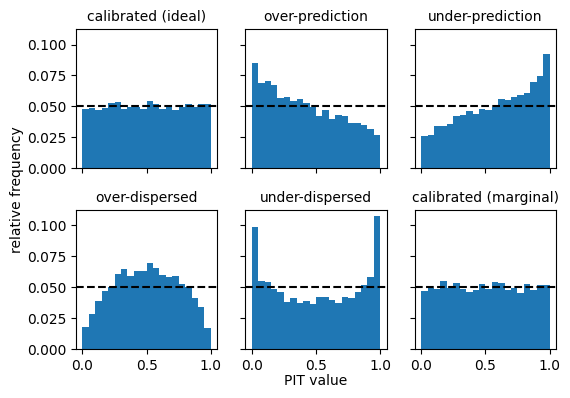

In [3]:
# now plot the rank histogram for each forecaster

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(6, 4))

for histval, i in zip(histogram_values, range(6)):
    row, col = int(i / 3), i % 3
    axes[row, col].bar(histval['bin_centre'].values, histval.values, width=1/n_bins)
    axes[row, col].axhline(y=1/n_bins, color='k', linestyle='--')
    axes[row, col].set_title(histval.name, fontsize=10)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)
fig.text(0.5, 0.01, 'PIT value', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')

fig.show()

These illustrate basic characteristic shapes of PIT histograms.

- Calibrated forecasters (ideal and marginal) have flat histograms.
- Forecasters with dispersion issues have U-shaped or inverted U-shaped histograms, with too many observations falling either in the centre of the distribution (if over-dispersed) or in the tails of the distribution (if under-dispersed).
- Forecasters with bias (over- or under-prediction) have asymmetric histograms.

### PIT diagrams

PIT diagrams (similar to PIT uniform probability plots) provide another way of visualising miscalibration. A PIT diagram is a plot of graph of the empirical CDF of the PIT values for the set of forecast cases. If the PIT values are uniformly distributed, as would be the case for a probabilistically calibrated system, then graph will lie close to diagonal line, which is the graph of the CDF of the standard uniform distribution.

Plotting points for the PIT diagram are obtainable from the `.plotting_points()` method. Let's get the plotting points for all six forecasters and look at the output for the "calibrated (ideal)" forecaster.

In [4]:
plotting_points = [pit.plotting_points() for pit in pit_list]
plotting_points[0]

<xarray.DataArray 'calibrated (ideal)' (pit_x_value: 20004)> Size: 160kB
array([0., 0., 0., ..., 1., 1., 1.])
Coordinates:
  * pit_x_value  (pit_x_value) float64 160kB 0.0 0.0 5.754e-05 ... 1.0 1.0 1.0

Values in the array give the y-values for the PIT diagram, while values in the "pit_x_value" dimension give the corresponding x-values.

Here are the PIT diagrams for all 6 forecasters.

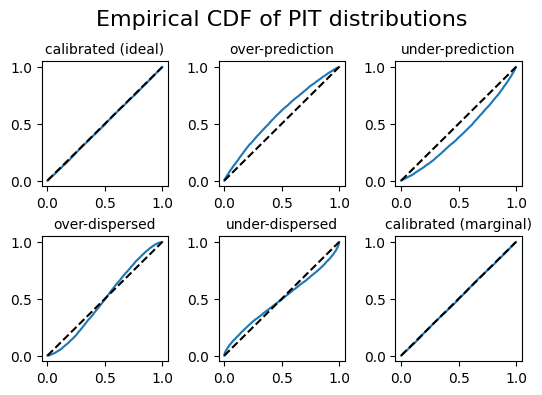

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4))

for ppoints, i in zip(plotting_points, range(6)):
    row, col = int(i / 3), i % 3
    axes[row, col].plot(ppoints['pit_x_value'].values, ppoints.values)
    axes[row, col].plot([0, 1], [0, 1], color='k', linestyle='--')
    axes[row, col].set_title(ppoints.name, fontsize=10)

fig.suptitle("Empirical CDF of PIT distributions", fontsize=16)
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

The PIT diagrams give the characteristic shapes for different types of miscalibration.

Output from the `.plotting_points()` method gives duplicate values in the "pit_x_value" dimension. That is because the empirical distribution will has discontinuities (or veritical jumps in the plot). Duplicate values among coordinates can sometimes cause problems. The `plotting_points_parametric()` method provides the same information as `plotting_points` but without duplicate coordinate values.

### Expected value and Variance of PIT

The expected value and variance of the empirical PIT distribution can be useful statistics for diagnosing different types of miscalibration. If the forecasting system is calibrated then the distribution of PIT values will be approximately uniform, with an expected value of $1/2$ and a variance of $1/12$. Large departures from these values can indicate bias or dispersion problems with the forecast system. The `.expected_value()` and `.variance()` methods give the values.

In [6]:
# expected value of PIT for the "calibrated (ideal)" forecaster, which is close to 1/2
pit_list[0].expected_value()

<xarray.DataArray 'calibrated (ideal)' ()> Size: 8B
array(0.50370607)

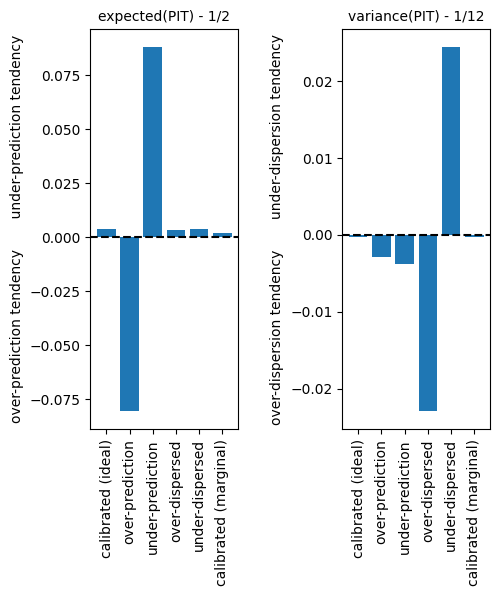

In [7]:
exp_values = [float(pit.expected_value() - 1/2) for pit in pit_list]
var_values = [float(pit.variance() - 1/12) for pit in pit_list]
fcst_labels = [fcst_at_obs.name for fcst_at_obs in fcst_at_obs_list]

fig, axes = plt.subplots(1, 2, figsize=(5, 5))

axes[0].axhline(y=0, color='k', linestyle='--')
axes[1].axhline(y=0, color='k', linestyle='--')

axes[0].set_ylabel('over-prediction tendency       under-prediction tendency')
axes[1].set_ylabel('over-dispersion tendency       under-dispersion tendency')


axes[0].bar(fcst_labels, exp_values)
axes[1].bar(fcst_labels, var_values)

axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)

axes[0].set_title('expected(PIT) - 1/2', fontsize=10)
axes[1].set_title('variance(PIT) - 1/12', fontsize=10)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=.7, hspace=0.4)

fig.show()

### The alpha score

The alpha score (Renard et al, 2010) is a summary statistic for the disparture of the PIT distribution for a set of forecast cases from the standard uniform distribution. It measures the integrated absolute difference between the PIT CDF and the standard uniform CDF (i.e., the area between the PIT diagram plot and the diagonal). The `.alpha_score` method calculates the values.

In [8]:
# alpha score for forecaster A
pit_list[0].alpha_score()

<xarray.DataArray ()> Size: 8B
array(0.00374534)

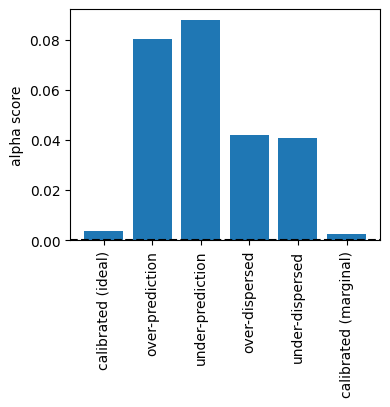

In [9]:
alpha_scores = [float(pit.alpha_score()) for pit in pit_list]

fig, axes = plt.subplots(1, 1, figsize=(4, 3))

axes.axhline(y=0, color='k', linestyle='--')
axes.set_ylabel('alpha score')

axes.bar(fcst_labels, alpha_scores)

axes.tick_params(axis='x', labelrotation=90)

fig.show()

The calibrated forecast systems have the lower alpha scores.

## Case 2: Predictive distributions are parametric with discontinuities

We consider a process $Z_t$, where $Z_t = \max(0, Y_t)$ for $t=0, 1, \ldots, m$ and $Y_t$ is the normal generated process of Case 1. We'll call this the "clipped process", since the observations are generated from the old set of observations as follows:

In [10]:
obs_clipped = obs.clip(min=0)

The six forecasters of Case 1 make corresponding forecasts for $Z_t$ by clipping their predictive CDFs accordingly. We'll just focus on the "calibrated (ideal)" forecaster, to demonstrate how to handing distributions with discontiuities.

Suppose that $\mu_t=0.5$ for a particular $t$. The forecaster's predictive CDF for $Y_t$ (black dotted curve) and $Z_t$ (red solid curve) are shown below:

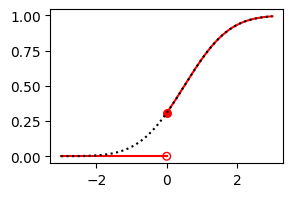

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

xvals = np.linspace(-3, 3, 1000)
yvals = norm.cdf(xvals, loc=0.5)

ax.plot([-3, 0], [0, 0], color='r', linestyle='-')
ax.scatter(0, norm.cdf(0, loc=0.5), color='r', marker='o', s=30)
ax.scatter(0, 0, color='r', marker='o', s=30, facecolor='none')
ax.plot(xvals[xvals >= 0], yvals[xvals >= 0], color='r', linestyle='-')
ax.plot(xvals, yvals, color='k', linestyle=':')

fig.show()

To use `Pit_fcst_at_obs` whenthe predictive CDF $F$ has discontinuities, we need to suppy the `fcst_at_obs` value $F(y)$ at the observation $y$, and also the left-hand limit `fcst_at_obs_left` value $\lim_{x\uparrow y}F(x)$ to account for any discontinuity.

First, let's see what happens if we don't supply `fcst_at_obs_left` values (in which case the predictive CDFs are assumed to be continuous):

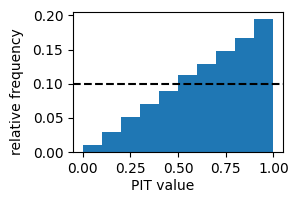

In [12]:
# evaluate the clipped observations at the normal CDF
fcst_at_obs = xr.DataArray(
    data=norm.cdf(obs_clipped, loc = mu, scale = 1),
    dims=['time'],
    coords={'time': range(n_time)},
)

# generate PIT object
pit = Pit_fcst_at_obs(fcst_at_obs)

# get histogram values
bins = 10
hist_vals = pit.hist_values(bins)

# plot the PIT histogram
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.bar(hist_vals['bin_centre'].values, hist_vals.values, width=1/bins)
ax.axhline(y=1/bins, color='k', linestyle='--')

fig.text(0.5, 0.01, 'PIT value', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2, wspace=.7, hspace=0.4)
fig.show()

The PIT histogram is characteristic of a forecast system with strong under-prediction tendency: about 19% of the observations are falling in the top decile of the predictive distributions. This is because we have not accounted for the discontinuity. We rectify this by also supplying the left-hand limits of the predictive CFDs at the observations.

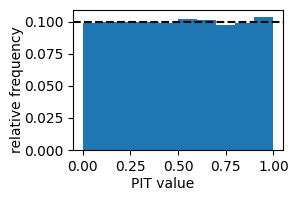

In [13]:
fcst_at_obs_left = fcst_at_obs.where(obs_clipped > 0, 0)

# generate PIT object
pit = Pit_fcst_at_obs(fcst_at_obs, fcst_at_obs_left=fcst_at_obs_left)

# get histogram values
bins = 10
hist_vals = pit.hist_values(bins)

# plot the PIT histogram
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.bar(hist_vals['bin_centre'].values, hist_vals.values, width=1/bins)
ax.axhline(y=1/bins, color='k', linestyle='--')

fig.text(0.5, 0.01, 'PIT value', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2, wspace=.7, hspace=0.4)
fig.show()

We get a flat histogram, as expected since the observations are have been sampled from a distribution that matches the forecaster's distribution.

The mathematics behind PIT when the the predictive CDF has discontuities is explained by Taggart (2022), inspired by the work of Wand and Robertson (2011) and Gneiting and Ranjan (2013).

## Case 3: Predictions are in the form of ensemble forecasts

Ensemble forecasts are treated as empirical CDFs, which have as many discontinuities as there are ensemble values. These are handles correctly by the `Pit` class. NaN values among the ensemble members are treated as though there were simply fewer ensemble members.

We'll give two examples here, both involving the "calibrated (ideal)" forecaster, for the processes $Y_t$ and $Z_t$. First we'll create a 100 member ensemble for $Y_t$ by randomly sampling the forecasters predictive distribution.

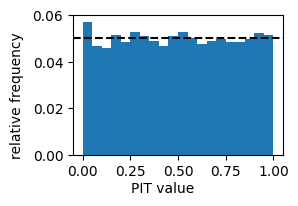

In [14]:
n_ensemble = 100  # ensemble size

# broadcast mu_t to have the same shape as the set of ensemble forecasts
mu_broadcast = np.broadcast_to(mu, (n_ensemble, n_time))

# generate the ensemble forecasts
np.random.seed(seed=43)
fcst_ens = xr.DataArray(
    data=norm.rvs(loc=mu_broadcast),
    dims=['ensemble_member', 'time'],
    coords={'ensemble_member': range(n_ensemble), 'time': range(n_time)}
)

# calculate PIT: we need to specify the forecasts, observations, ensemble member dimension
# and forcecast type (the default is "ensemble")
pit = Pit(fcst_ens, obs, "ensemble_member", fcst_type="ensemble")

# plot the histogram
bins = 20
hist_vals = pit.hist_values(bins)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.bar(hist_vals['bin_centre'].values, hist_vals.values, width=1/bins)
ax.axhline(y=1/bins, color='k', linestyle='--')

fig.text(0.5, 0.01, 'PIT value', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2, wspace=.7, hspace=0.4)
fig.show()

Note that the values of the first bin in the histogram is a little high. This is because of two reasons.

1. The histogram bins are $[0, 0.5]$, $(0.5, 0.1]$, $(0.1, 0.15]$, ..., $(0.95, 1]$. That is, the right endpoints are always included (the default), but the left endpoint of the first bin is also included.
2. The ensemble is being treated as an empirical CDF, which means that any observation with a value less then the smallest ensemble value has a PIT value of 0.

The combination of these two facts concentrates more PIT values in the first bin. If we instead call `pit.hist_values(bins, right=False)`, we'll transfer the problem from the fisrt bin to the last bin. Ultimately, the problem stems from the fact that the empirical CDF is not perfectly calibrated. For this reason, users may prefer to look use `scores.probability.rank_histogram` to generate similar plots where the ensemble is not being interpreted as an empirical CDF. Strengths and weaknesses of the two approaches are further discuused in the [rank histogram tutorial](./Rank_Histogram.ipynb).

A major advantage of using `Pit` is access to all the other PIT methods, such as `.plotting_points()`, `.expected_value()` and `.alpha_score()`. Here is a quick method of generating a PIT diagram for calibrated forecaster and the clipped process $Z_t$.

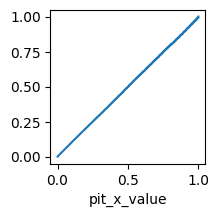

In [15]:
fcst_ens_clipped = fcst_ens.clip(min=0)
pit = Pit(fcst_ens_clipped, obs_clipped, "ensemble_member", fcst_type="ensemble")
pit.plotting_points().plot(figsize=(2, 2))


## Case 4: Predictions are CDFs (non-parametric)

The `Pit` class can also accept forecasts in the form of an array of predictive CDF values. Intermediate values are determined by linear interpolation. Discontinuities in the predictive CDF can be accounted for by supplying `fcst_left` values.

Here is an example for the "calibrated (ideal)" forecaster for the process $Z_t$.

/home/rtaggar/scores/src/scores/probability/pit_impl.py:859: UserWarning: Some observations were greater than the maximum `threshold_dim` value in your `fcst`. The value of the fcst CDF at these observations will be set to 1.
  warnings.warn(


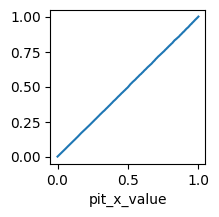

In [16]:
# We supply an array of values F(x) where x is from `xvals` as below.
xvals = np.arange(-5, 5, 0.1)
# Note that it is critical that 0 is amongst the x values, as this is where large discontinuities often occur.
# So we'll round the values as a precaution and check that 0 is in the set
xvals = np.round(xvals, 1)
assert 0 in xvals

n_xvals = len(xvals)

mu_broadcast = np.broadcast_to(mu, (n_xvals, n_time))
xvals_broadcast = np.broadcast_to(xvals, (n_time, n_xvals)).T

# array of values of the normal CDF
fcst_cdf = xr.DataArray(
    data=norm.cdf(xvals_broadcast, loc=mu_broadcast),
    dims=['x', 'time'],
    coords={'x': xvals, 'time': range(n_time)}
)
# array of left hand limits of the clipped CDF
fcst_cdf_left = fcst_cdf.where(fcst_cdf['x'] > 0, 0)
# array of right-hand limits of the clipped CDF:
fcst_cdf_right = fcst_cdf.where(fcst_cdf['x'] >= 0, 0)

# calculate PIT. Note that fcst_type is now "cdf" and we need to supply 'x' as the dimension indexing CDF values
pit = Pit(fcst_cdf_right, obs_clipped, 'x', fcst_type="cdf", fcst_left=fcst_cdf_left)
pit.plotting_points().plot(figsize=(2, 2))


The PIT diagram lies close to the diagonal, as it should for a calibrated forecast.

## Case 5: dimension handling and weights.

`Pit` and `Pit_fcst_at_obs` handles dimensions and weights in a similarly to other `scores` metrics. We conclude with an example to illustrate this.

We adapt an example from Hamill (2001), devised to how that conditionally mis-calibrated forecast systems can have flat PIT histograms. That is, while a calibrated system has an expected flat PIT histogram, a flat PIT histogram does not imply that the forecast system is well-calibrated.


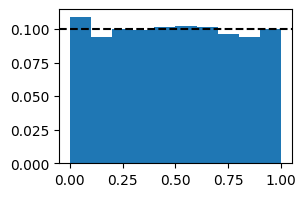

In [17]:
# generate observations for three locations, all from the standard normal distribution N(0,1)
np.random.seed(seed=44)
obs = xr.DataArray(
    data=norm.rvs(loc=0, scale=1, size=(3, n_time)),
    dims=['location', 'time'],
    coords={'location': ['city', 'hill', 'valley'], 'time': range(n_time)}
)

# number of ensemble members in each forecast
n_member = 100
# ensemble forecasts for the city are under-predictions N(-0.5, 1)
fcst_city = xr.DataArray(
    data=norm.rvs(loc=-0.5, scale=1, size=(n_time, n_member, 1)),
    dims=['time', 'ens_member', 'location'],
    coords={'time': range(n_time), 'ens_member': range(n_member), 'location': ['city']}
)
# ensemble forecasts for the hill are over-predictions N(0.5, 1))
fcst_hill = xr.DataArray(
    data=norm.rvs(loc=0.5, scale=1, size=(n_time, n_member, 1)),
    dims=['time', 'ens_member', 'location'],
    coords={'time': range(n_time), 'ens_member': range(n_member), 'location': ['hill']}
)
# ensemble forecasts for the valley are over-dispersed N(0, 1.3**2)
fcst_valley = xr.DataArray(
    data=norm.rvs(loc=0, scale=1.3, size=(n_time, n_member, 1)),
    dims=['time', 'ens_member', 'location'],
    coords={'time': range(n_time), 'ens_member': range(n_member), 'location': ['valley']}
)
# combine ensemble forecasts into one data array
fcst = xr.concat([fcst_city, fcst_hill, fcst_valley], 'location')

# include some weights - we'll start with equal weighting on city, hill and valley forecasts
weights = xr.DataArray(data=[1, 1, 1], dims=['location'], coords={'location': ['city', 'hill', 'valley']})

# calculate PIT
pit = Pit(fcst, obs, "ens_member", reduce_dims='all', weights=weights)

# plot the PIT histogram
bins = 10
pit_hist = pit.hist_values(bins)

fig, axes = plt.subplots(1, 1, figsize=(3, 2))
plt.bar(pit_hist['bin_centre'].values, pit_hist.values, width=1/bins)
plt.axhline(y=1/bins, color='k', linestyle='--')
fig.show()

# We get an almost flat histogram

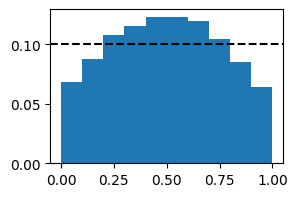

In [18]:
# However, we can expose conditional miscalibration by putting a higher weight on some locations and a lower weight on others.

# For example, here is the rank histogram with a high weight on valley forecasts:
weights = xr.DataArray(data=[1, 1, 10], dims=['location'], coords={'location': ['city', 'hill', 'valley']})
# calculate PIT
pit = Pit(fcst, obs, "ens_member", reduce_dims='all', weights=weights)

# plot the PIT histogram
pit_hist = pit.hist_values(bins)

fig, axes = plt.subplots(1, 1, figsize=(3, 2))
plt.bar(pit_hist['bin_centre'].values, pit_hist.values, width=1/bins)
plt.axhline(y=1/bins, color='k', linestyle='--')
fig.show()

# We get an inverted U shaped histogram

## Things to try next

Only the "calibrated (ideal)" forecaster was used to illustrate Cases 2, 3 and 4. Try expand Cases 2, 3 and 4 by including all the forecasters used in Case 1.


## References

- Gneiting, T., & Ranjan, R. (2013). Combining predictive distributions. Electron. J. Statist. 7: 1747-1782. https://doi.org/10.1214/13-EJS823
- Renard, B., Kavetski, D., Kuczera, G., Thyer, M., & Franks, S. W. (2010). Understanding predictive uncertainty in hydrologic modeling: The challenge of identifying input and structural errors. Water Resources Research, 46(5). https://doi.org/10.1029/2009WR008328
- Taggart, R. J. (2022). Assessing calibration when predictive distributions have discontinuities. Bureau Research Report 64, http://www.bom.gov.au/research/publications/researchreports/BRR-064.pdf
- Wang, Q. J., & Robertson, D. E. (2011). Multisite probabilistic forecasting of seasonal flows for streams with zero value occurrences. Water Resources Research, 47(2). https://doi.org/10.1029/2010WR009333